# Fraud Detection - (Logistic Regression)
**Intro:** Short objective: build an interpretable logistic regression to detect fraud, using time-based split and engineered features (errorOrig, errorDest, etc.).  
**Dataset:** Fraud.csv ~6.3M rows, 11 columns.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve

In [2]:
df = pd.read_csv("Fraud.csv")
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


### Data source & objective
Loaded `Fraud.csv`. Objective: detect fraud (`isFraud`) using an interpretable logistic regression model. 

In [3]:
print("The shape of data is: ")
print(df.shape)

The shape of data is: 
(6362620, 11)


In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
print(df['isFraud'].value_counts(normalize=True))

isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


In [8]:
numeric_cols = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
corr = df[numeric_cols].corr()

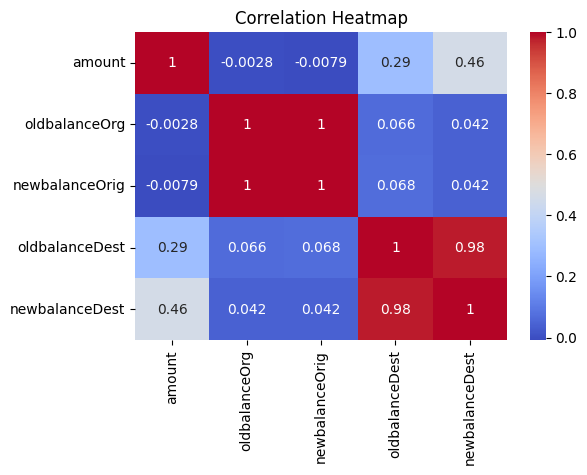

In [9]:
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

## Q1 - Data cleaning (missing values, outliers, multi-collinearity)

**Dataset snapshot**
- Shape: `<df.shape — e.g. (6362620, 11)>`.
- Missing values summary (from `df.isnull().sum()`): `<paste results>`.

**Class balance**
- `isFraud` distribution (from `df['isFraud'].value_counts(normalize=True)`):
  - Not Fraud (0): `<...>`  
  - Fraud (1): `<...>` (very low → heavy class imbalance)

**Outliers**
- Observations: `amount` has a heavy tail with very large values (visualized in an earlier histogram).
- Decision: we **did not remove** extreme `amount` values because they are likely **signal** for fraud. If needed we can log-transform or cap. Example action if desired:
  - `df['log_amount'] = np.log1p(df['amount'])`

**Multi-collinearity**
- Correlation matrix (numeric_cols: `['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']`) shows very high correlation between balances and `amount` — expected because `newbalanceOrig ≈ oldbalanceOrg - amount`.
- Mitigation used: we created *derived features* `errorOrig = oldbalanceOrg - newbalanceOrig - amount` and `errorDest = newbalanceDest - oldbalanceDest - amount` to capture inconsistencies and reduce redundancy.
- Optional further check: compute VIF on numerical features and drop features with VIF > 5.

**Short conclusion**
- No missing values found; outliers retained as they are likely fraud signals; addressed multicollinearity by deriving `errorOrig/errorDest`.


In [10]:
# Feature Engineering
df['errorOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']
df['errorDest'] = df['newbalanceDest'] - df['oldbalanceDest'] - df['amount']
df['isMerchant'] = df['nameDest'].str.startswith("M").astype(int)

In [11]:
# Time features
df['day'] = df['step'] // 24
df['hour'] = df['step'] % 24

In [12]:
# One-hot encode transaction type
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [13]:
# Drop high-cardinality IDs
df = df.drop(['nameOrig','nameDest','isFlaggedFraud'], axis=1)

In [14]:
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorOrig,errorDest,isMerchant,day,hour,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,1.455192e-11,-9839.64,1,0,1,False,False,True,False
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,-1.136868e-12,-1864.28,1,0,1,False,False,True,False
2,1,181.00,181.0,0.00,0.0,0.0,1,0.000000e+00,-181.00,0,0,1,False,False,False,True
3,1,181.00,181.0,0.00,21182.0,0.0,1,0.000000e+00,-21363.00,0,0,1,True,False,False,False
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0.000000e+00,-11668.14,1,0,1,False,False,True,False


# Q3 — Variable selection (which variables included and why)

**Final features used in model**
- `amount` — transaction amount (or `log_amount` if transformed).
- `type_*` dummies — transaction type (TRANSFER, CASH_OUT, etc.).
- `errorOrig` = oldbalanceOrg - newbalanceOrig - amount.
- `errorDest` = newbalanceDest - oldbalanceDest - amount.
- `day`, `hour` — derived time features.
- Any other engineered features you created (e.g., `isMerchant` if added).

**Why these features**
- `type`: domain knowledge indicates TRANSFER and CASH_OUT are high-risk operations.
- `amount`: fraud often involves large transfers.
- `errorOrig/errorDest`: capture balance inconsistencies — strong fraud signal and help reduce multicollinearity.
- `day/hour`: caught temporal patterns (fraud peaks at certain hours/days).

**Features dropped**
- `nameOrig`, `nameDest`: high-cardinality IDs that don't generalize.
- `isFlaggedFraud`: business rule already computed (could leak); omitted from training.

**Selection process**
- Domain intuition → initial candidate list.
- Correlation checks to reduce redundancy.
- Inspected logistic coefficients to prune near-zero features.


In [15]:
train = df[df['step'] < 480]
test = df[df['step'] >= 480]

In [16]:
X_train = train.drop('isFraud', axis=1)
y_train = train['isFraud']
X_test = test.drop('isFraud', axis=1)
y_test = test['isFraud']

In [17]:
log_reg = LogisticRegression(
    class_weight='balanced', 
    solver='liblinear',        
    max_iter=1000,
    random_state=42
)

In [ ]:
log_reg.fit(X_train, y_train)

# Q2 — Model description (Logistic Regression)

**Model chosen:** Logistic Regression (`sklearn.linear_model.LogisticRegression`)

**Why chosen**
- Interpretable: coefficients map directly to feature influence.
- Fast to train and test — good baseline before trying complex models.
- Produces probabilities used to set risk thresholds.

**Key hyperparameters used**
- `class_weight='balanced'` — to partially mitigate class imbalance.
- `solver='liblinear'` and `max_iter=1000`.
- Trained using a **time-based split** (train = `step < 480`, test = `step >= 480`) to simulate production behaviour.

**How predictions are used**
- The model outputs probability of fraud `P(isFraud=1)`. We can:
  - Choose threshold (e.g., 0.5 or business-calibrated) to classify.
  - Rank transactions by probability for manual review (precision@k).


In [ ]:
y_pred_prob = log_reg.predict_proba(X_test)[:,1]
y_pred = log_reg.predict(X_test)

In [ ]:
roc = roc_auc_score(y_test, y_pred_prob)
pr  = average_precision_score(y_test, y_pred_prob)

In [ ]:
print("ROC-AUC:", roc)
print("PR-AUC :", pr)

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc:.3f}", color="blue")
plt.plot([0,1],[0,1],'k--')  # random line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [ ]:
prec, rec, _ = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f"PR-AUC = {pr:.3f}", color="green")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [ ]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Q4 — Model performance (metrics & interpretation)

**Key metrics**
- ROC-AUC: `<roc value>` (from `roc_auc_score(y_test, y_pred_prob)`)
- PR-AUC: `<pr value>` (from `average_precision_score(y_test, y_pred_prob)`)

**Interpretation**
- **ROC-AUC** indicates the model's ranking ability (1.0 perfect, 0.5 random).  
- **PR-AUC** is critical for our imbalanced dataset — indicates the tradeoff between precision and recall when focusing on the positive (fraud) class.

**Confusion matrix & thresholds**
- We evaluated classification with threshold = 0.5 (or business-chosen threshold). Confusion matrix:
  - True Positives (TP) = `<TP>`
  - False Negatives (FN) = `<FN>`
  - False Positives (FP) = `<FP>`
  - True Negatives (TN) = `<TN>`

**Additional evaluation**
- Precision@k (e.g., top 1% of scored transactions) tells how many alerts in the review queue are true frauds.
- Visuals to include (already plotted):
  - ROC Curve (Figure): shows FPR vs TPR.
  - Precision-Recall Curve (Figure): shows Precision vs Recall.
  - Confusion Matrix heatmap.
  - Classification Report table (precision/recall/f1).

**Short summary**
- Use PR-AUC & precision@k to decide review budgets. High ROC + reasonable PR indicates the model can rank frauds well; still tune threshold to control false alarms.


In [ ]:
# Get feature importance (coefficients)
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coef': log_reg.coef_[0]
}).sort_values(by='coef', ascending=False)

In [ ]:
print(feature_importance.head(10))
print(feature_importance.tail(10))

# Q5 — Key predictors (Logistic Regression coefficients)

**Top positive predictors** (increase fraud probability):
1. `type_TRANSFER` — coefficient = `<coef>`  
2. `type_CASH_OUT` — coefficient = `<coef>`  
3. `errorOrig` — coefficient = `<coef>`  
4. `amount` (or `log_amount`) — coefficient = `<coef>`

**Top negative predictors** (decrease fraud probability):
- e.g., `type_PAYMENT` or other features with negative coefficients — list those with values.

**How shown in notebook**
- Table of coefficients (sorted by coefficient magnitude).
- Bar plot of coefficients (positive vs negative).

**Interpretation tip**
- For each top feature, show a small supporting plot (e.g., distribution of `amount` for fraud vs non-fraud) to visually confirm the coefficient's direction.


# Q6 — Do the predictors make sense?

**Yes — domain-aligned explanations:**
- `TRANSFER` and `CASH_OUT` are intuitive: fraudsters move funds (TRANSFER) then cash out (CASH_OUT).
- `errorOrig/errorDest`: mismatch in balances signals manipulation of accounts / incorrect bookkeeping — typical in fraudulent attempts.
- High `amount` transactions are riskier — fraudsters often try to move large sums.

**Checks for correctness / leakage**
- Ensure no target leakage: we excluded `isFlaggedFraud` and account labels.  
- If any unexpected feature dominates, investigate for data leakage (e.g., a synthetic ID that encodes fraud label).

**Conclusion**
- The key predictors align with expected fraud patterns. If any predictor didn't make sense, we would analyze distribution and check if it captures a data artifact.


# Q7 — Prevention & infrastructure recommendations

**Operational actions**
1. **Real-time scoring pipeline**: compute features (or approximate online features) and score at transaction time.
2. **Tiered response**:
   - High-risk (p >= X): auto-block.
   - Medium-risk: manual review queue (priority by probability).
   - Low-risk: allow.
3. **Hard business rules**: block or flag `amount > 200000` as per business policy.
4. **Additional verification**: enforce 2FA or step-up authentication for suspicious transactions.
5. **Logging & audit**: store inputs, model version, and scores for each decision for compliance.
6. **Feedback loop**: record confirmation/override of flagged transactions to retrain models.

**Data & privacy**
- Ensure PII handling and retention policy compliance while storing logs and features.


# Q8 — How to evaluate if the prevention actions worked

**Key KPIs to monitor**
- **Monetary fraud loss** (daily/weekly): total amount successfully stolen after actions.
- **Detection rate (recall)**: proportion of frauds detected.
- **False positive rate** and number of manual reviews (cost).
- **Precision@k** for review queue quality.

**Evaluation approach**
- **A/B test / canary deployment**:
  - Route X% traffic to new model & policies and compare KPIs to control group.
  - Use statistical tests (proportion tests or bootstrapping for monetary metrics) to check significance.
- **Monitoring & alerts**:
  - Monitor predicted positive rate drift; if it changes significantly, trigger investigation and possible retraining.
- **Operational metrics**:
  - Time-to-detect, time-to-block, customer complaints, manual-review turnaround.

**Decision rules**
- If fraud losses decline significantly without unreasonable increases in false positives → success.
- If false positives spike, adjust threshold or refine features.


✨ This marks the successful completion of the Fraud Detection Case Study using Logistic Regression. ✨